# Install and load dependencies

In [1]:
%pip install pydeseq2
%pip install scanpy
%pip install sanbomics
%pip install bioinfokit
%pip install gseapy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from functools import reduce
from sanbomics.plots import volcano
from bioinfokit import analys,visuz
from gseapy.plot import gseaplot

import pandas as pd
import seaborn as sns
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import sys
import gseapy as gp

/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Run DESeq2

In [3]:
merged = pd.read_csv('../data/raw/primary_and_goodDiffs_metadata.tsv', delimiter='\t')
merged.set_index(merged.columns[0], inplace=True)
merged.sort_index(inplace=True)

In [4]:
merged *= 100
merged = merged.astype(int)

In [5]:
labels = ['Diff-CM'] * 16 + ['LV'] * 5

metadata = pd.DataFrame(zip(merged.index, labels),
                        columns = ['Sample', 'Condition'])
metadata = metadata.set_index('Sample')

In [6]:
dds = DeseqDataSet(counts=merged,
            metadata=metadata,
            design_factors="Condition",
            ref_level = ["Condition", "LV"])

In [7]:
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shahjess/anaconda3/lib/python3.11/site-pac

In [8]:
stat_res = DeseqStats(dds, contrast = ('Condition','LV','Diff-CM'))

stat_res.summary()
res = stat_res.results_df

Running Wald tests...


Log2 fold change & Wald test p-value: Condition LV vs Diff-CM
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG       6473.360017       -5.477397  1.188845 -4.607327  4.078789e-06   
A1BG-AS1   1035.227209       -3.009348  0.911537 -3.301401  9.620343e-04   
A1CF        769.341202       -9.913422  1.773194 -5.590715  2.261367e-08   
A2M       26097.383588        1.711530  0.607596  2.816890  4.849115e-03   
A2M-AS1    4964.991209       -2.514362  0.982389 -2.559435  1.048424e-02   
...                ...             ...       ...       ...           ...   
ZXDB       1475.637653       -1.358864  0.440082 -3.087750  2.016780e-03   
ZXDC       2164.886927       -0.214870  0.276792 -0.776287  4.375794e-01   
ZYG11B     2967.908099        0.053419  0.515651  0.103595  9.174904e-01   
ZYX        8820.294113        1.346575  0.569701  2.363651  1.809583e-02   
ZZEF1      1845.911083        0.600711  0.321136  1.870582  6.140298e-02   

                  padj  


... done in 0.52 seconds.



# Heat Map

In [9]:
sys.setrecursionlimit(10000)  # Set a higher recursion limit (adjust the value as needed)

/Users/shahjess/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shahjess/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


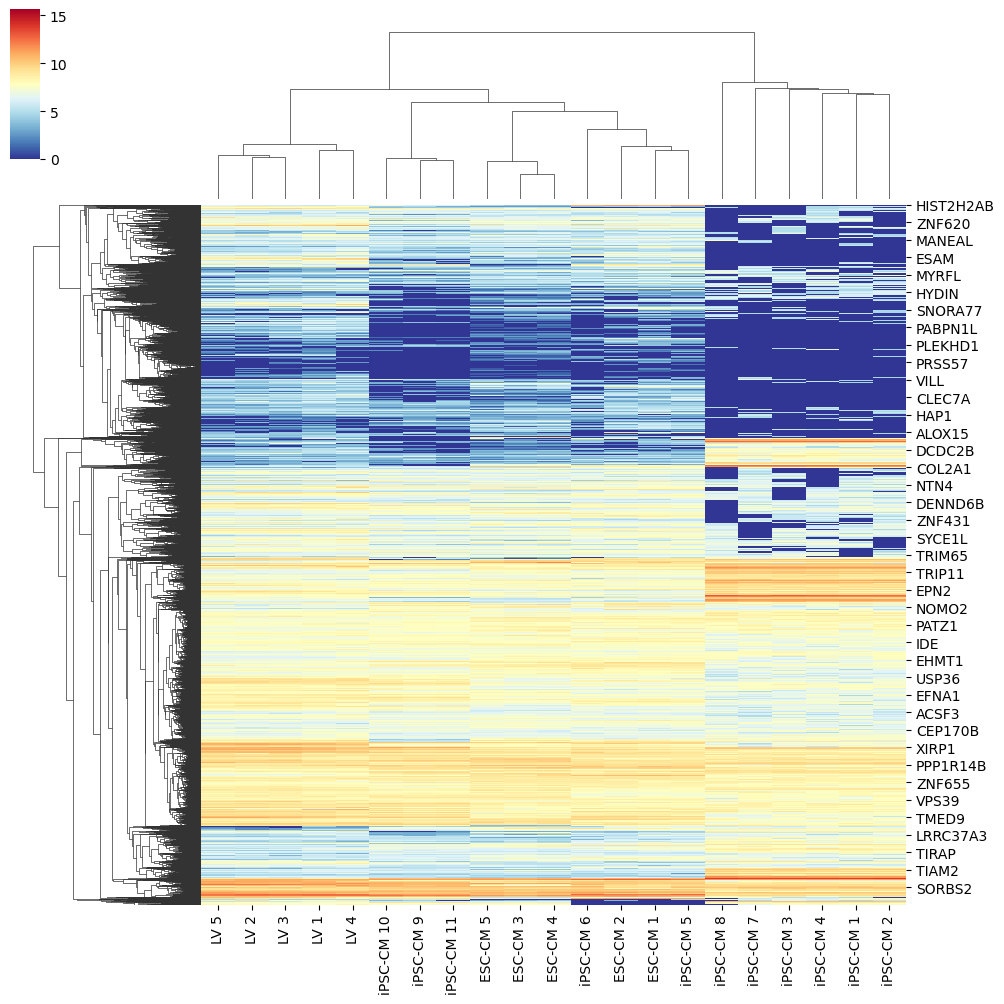

In [10]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds_res = dds[:, res.index]

pattern_repetitions = {'ESC-CM': 5, 'iPSC-CM': 11, 'LV': 5}
col_labels = [f'{pattern} {i}' for pattern, repetitions in pattern_repetitions.items() for i in range(1, repetitions + 1)]

grapher_res = pd.DataFrame(dds_res.layers['log1p'].T,
                       index=dds_res.var_names, columns=col_labels)

sns.clustermap(grapher_res, cmap='RdYlBu_r',cbar_pos=(0, .85, .03, .15))
plt.savefig('../figures/Fig 1a Diff vs LV Heatmap.png')

# Heatmap of cardiac genes

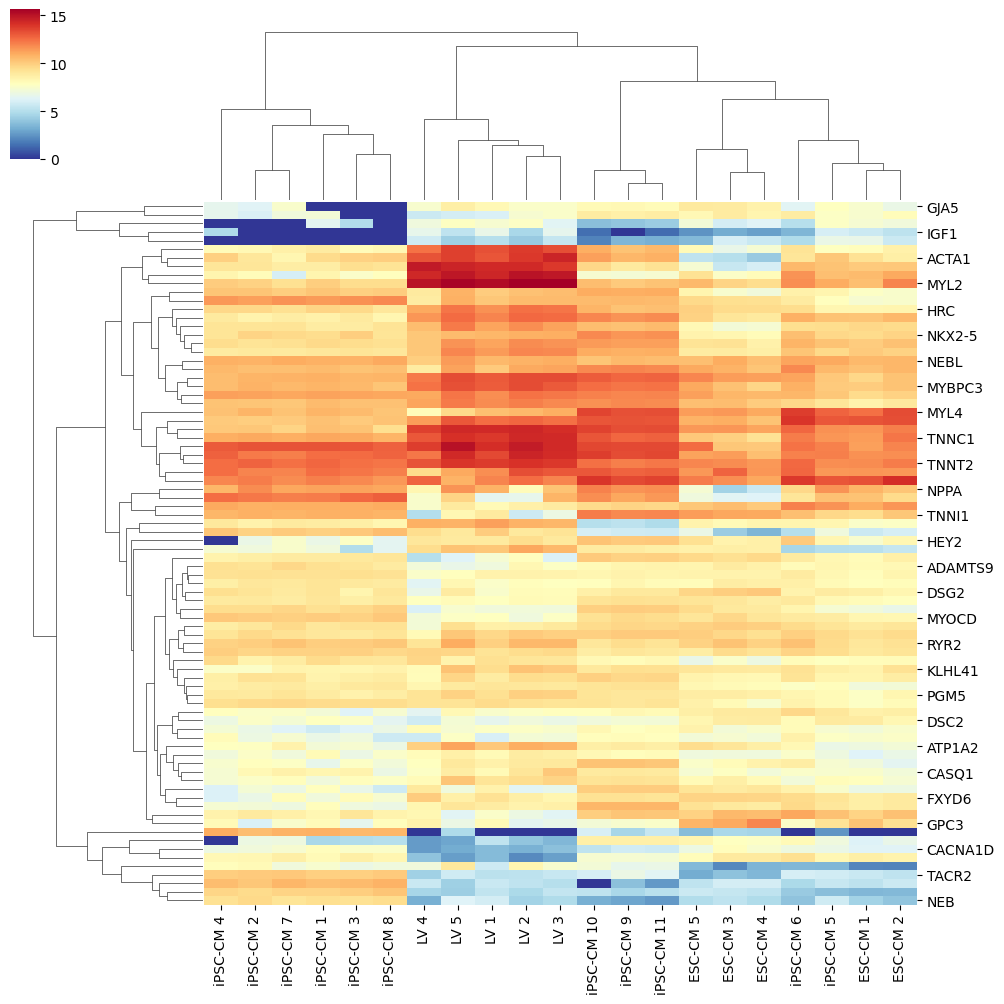

In [11]:
cardiac_genes = pd.read_csv('../data/raw/cardiac_genes.csv', delimiter='\t')
common_genes = cardiac_genes['Gene'][cardiac_genes['Gene'].isin(grapher_res.index)]
subset_grapher_res = grapher_res.loc[common_genes]

sns.clustermap(subset_grapher_res, cmap='RdYlBu_r',cbar_pos=(0, .85, .03, .15))
plt.savefig('../figures/Fig 1b Diff vs LV Cardiac Heatmap.png')

# Differentially Expressed Genes |Log2FC| >1

In [12]:
#Filter based on p-value
ranking = res[res['pvalue'] <= 0.05]

#Sort based on abs log2 fold change
ranking = ranking[['log2FoldChange']].dropna()
ranking['abs_l2FC'] = ranking['log2FoldChange'].abs()
ranking.sort_values(by='abs_l2FC', ascending=False, inplace=True)
ranking = ranking[ranking['abs_l2FC'] > 1]

ranking.drop(columns=['abs_l2FC'], inplace=True)


ranking

,log2FoldChange
CYP4F24P,16.698128
HBA2,16.442628
SLC24A5,-16.366089
GNG13,-16.333775
SMAD1-AS1,-15.855419
...,...
DCAF7,-1.002550
ALDH7A1,-1.002477
CGGBP1,-1.001272
MEF2C,-1.001214


In [13]:
pre_res = gp.prerank(rnk=ranking, # or rnk = rnk,
                     gene_sets='GO_Biological_Process_2021',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes'],
               pre_res.results[term]['gene %'],
               pre_res.results[term]['lead_genes'],])

out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes','gene %','lead_genes']).sort_values('nes').reset_index(drop = True)

out_df['abs_nes'] = abs(out_df['nes'])  # Create a new column with absolute NES values
out_df = out_df.sort_values('abs_nes', ascending=False).reset_index(drop=True)

out_df.drop('abs_nes', axis=1, inplace=True)

# Save the sorted DataFrame to a TSV file
# out_df.to_csv('GSEA/allDiff_primary_new.tsv', sep='\t', index=False)

out_df

2024-04-12 17:24:42,278 [INFO] Parsing data files for GSEA.............................
2024-04-12 17:24:42,278 [INFO] Enrichr library gene sets already downloaded in: /Users/shahjess/.cache/gseapy, use local file
2024-04-12 17:24:42,319 [INFO] 2485 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-04-12 17:24:42,320 [INFO] 3551 gene_sets used for further statistical testing.....
2024-04-12 17:24:42,320 [INFO] Start to run GSEA...Might take a while..................
2024-04-12 17:25:01,228 [INFO] Congratulations. GSEApy runs successfully................



,Term,fdr,es,nes,gene %,lead_genes
0,inflammatory response (GO:0006954),0.000000,0.629877,3.289512,18.89%,CCL11;FOLR2;CCL14;CCL13;HPR;CCL8;CCL18;ADORA3;...
1,cellular response to interferon-gamma (GO:0071...,0.000000,0.670362,3.272714,15.53%,HLA-DRA;CCL11;CCL14;CCL13;CCL8;CCL18;HLA-B;HLA...
2,defense response to bacterium (GO:0042742),0.000000,0.646463,3.008497,22.43%,CTSG;DEFA5;GNLY;FGR;TNFRSF14;LTF;FCER1G;ELANE;...
3,cytokine-mediated signaling pathway (GO:0019221),0.000000,0.475929,2.962674,19.04%,HLA-DRA;CCL11;CCL14;CTSG;RORC;LILRB2;CCL13;CCL...
4,cellular response to type I interferon (GO:007...,0.000000,0.695337,2.937024,24.81%,HLA-B;XAF1;PSMB8;OASL;IFI27;HLA-E;OAS2;RSAD2;M...
...,...,...,...,...,...,...
3546,negative regulation of nucleic acid-templated ...,0.999891,0.064335,0.378485,12.29%,ADIPOQ;SOX18;HEYL;TNFRSF4;CD38;CIITA;TWIST2;CB...
3547,negative regulation of phosphorylation (GO:004...,1.000000,-0.089841,-0.367104,91.07%,ACTN3;XDH;EPHB2;OCLN;BMP7;CDKN2A;INHBA;DNAJC10...
3548,cellular macromolecule biosynthetic process (G...,1.000000,-0.070475,-0.362484,71.57%,TICRR;BRIP1;TYMS;POLR2F;RAD9A;RMI2;CHEK1;CDK1;...
3549,protein complex oligomerization (GO:0051259),0.999923,-0.079419,-0.329709,33.68%,RS1;KCNC1;TMEM120B;POLQ;NLRC4;TP53BP1;KCNC3;AT...


In [14]:
filtered_df = out_df[out_df['Term'].str.contains('heart|cardiac', case=False)]

filtered_df

,Term,fdr,es,nes,gene %,lead_genes
132,heart process (GO:0003015),0.001568,0.828210,2.179944,9.81%,RAMP3;TNNI3;MYL2;ACE;SGCD;SGCG
184,heart contraction (GO:0060047),0.008457,0.506702,2.027844,27.42%,CASQ2;TNNI3;MYL2;SCN4B;TCAP;ACE;SGCD;SGCG;MYLK...
343,cardiac muscle contraction (GO:0060048),0.045023,0.490265,1.817543,27.42%,CASQ2;TNNI3;SCN4B;TCAP;MYLK2;SCN1B;GSN;ATP1A2;...
562,membrane repolarization during cardiac muscle ...,0.126619,0.684376,1.627629,17.38%,KCND3;KCNJ8;KCNIP2;KCNJ2
610,regulation of ventricular cardiac muscle cell ...,0.149100,0.669033,1.591982,12.66%,SCN4B;CAV3;SCN1B
...,...,...,...,...,...,...
3133,cardiac atrium morphogenesis (GO:0003209),1.000000,-0.228550,-0.674213,13.99%,NOG;BMP10;TGFB2
3301,adult heart development (GO:0007512),0.989776,0.270848,0.601473,6.32%,TCAP
3335,cardiac muscle cell differentiation (GO:0055007),1.000000,-0.202495,-0.585917,37.13%,NRG1;SLC8A1;SIK1;MYOCD;CXADR;BMP2
3356,positive regulation of cardiac epithelial to m...,0.991817,0.236914,0.577710,18.24%,TGFBR2;ENG


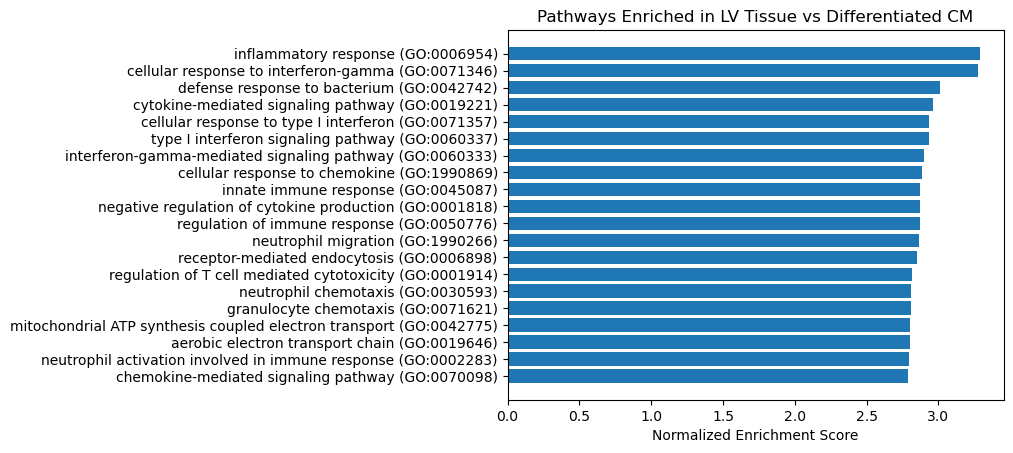

<Figure size 640x480 with 0 Axes>

In [15]:
primary_allDiff = out_df
primary_allDiff = primary_allDiff.sort_values(by='nes', key=lambda x: x, ascending=False)

sig = primary_allDiff[primary_allDiff['fdr'] <= 0.05]
import matplotlib.pyplot as plt

# 20 necessary paths
good_paths = sig.iloc[0:20]

fig, ax = plt.subplots()

# Example data
gos = good_paths['Term']
nes = abs(good_paths['nes'])
y_pos = np.arange(len(nes))

ax.barh(y_pos, nes, align='center')
ax.set_yticks(y_pos, labels=gos)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Normalized Enrichment Score')
ax.set_title('Pathways Enriched in LV Tissue vs Differentiated CM')

plt.show()
plt.savefig('../figures/Fig 1c Pathways enriched LV vs Diff.png')

# Compiling DE genes

In [16]:
res['Gene Name'] = res.index


In [17]:
DE = res[['Gene Name', 'log2FoldChange', 'pvalue']].copy()
DE['-log10FDR'] = -np.log10(DE['pvalue'])
DE['product'] = DE['-log10FDR'] * DE['log2FoldChange']
DE.sort_values(by='product', key=lambda x: abs(x), ascending=False, inplace=True)

#Filter based on p-value and log2FC
DE = DE[DE['pvalue'] <= 0.05]
DE = DE[abs(DE['log2FoldChange']) >= 1]

DE.drop(columns=['pvalue'], inplace=True)
DE = DE.reset_index(drop=True)

In [18]:
DE.to_csv('../data/DE_allDiff_primary_new.tsv', sep='\t', index=False)